In [1]:
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from collections import Counter
from utils import (
    visualize_images,
    verify_image_sizes,
    plot_bar,
    create_conditioning_distribution,
    create_conditioning_vector,
    show_generated,
    to_uint8,
    measure_fid,
    visualize_images_grid
)
from vae import VAE, train_vae
from diffusion_model import UNet, train_diffusion, generate

In [2]:
basic_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3) ])
dataset = datasets.ImageFolder("data/trafic_32", transform=basic_transforms)

In [3]:
analysis_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=14)
classes = dataset.classes
print("Class count:",len(classes))

Class count: 43


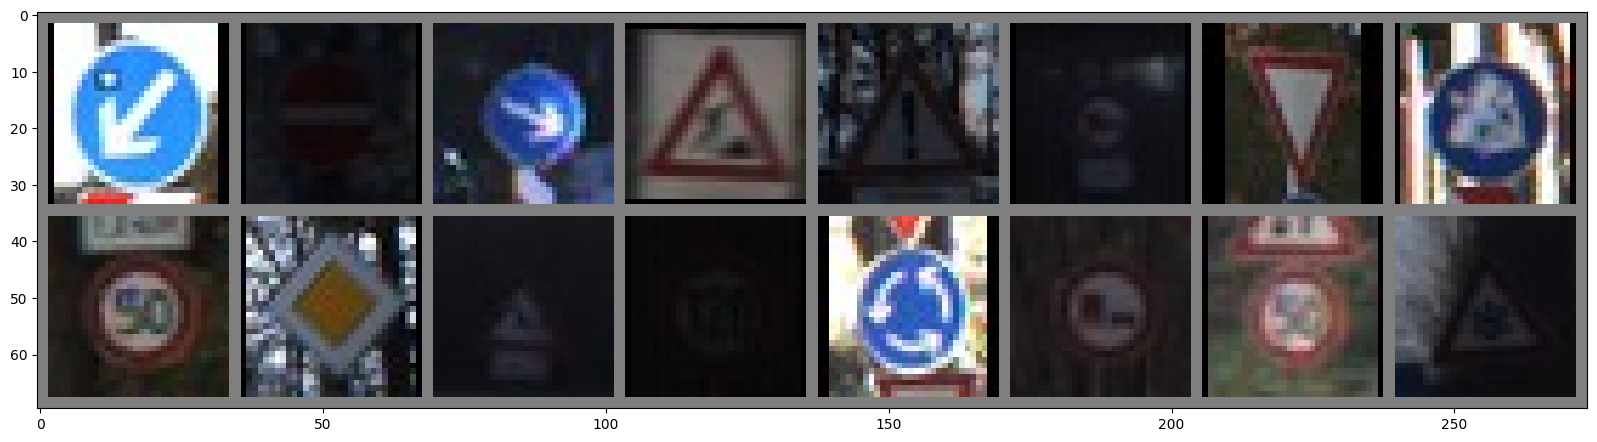

00039 00017 00038 00025 00018 00010 00013 00038 00002 00012 00031 00008 00040 00010 00002 00030


In [4]:
visualize_images(analysis_loader, classes, figsize=(20, 10))

In [5]:
verify_image_sizes(analysis_loader)

{torch.Size([3, 32, 32]): 39209}

We check the dataset classes distribution to get as close to the test set distribution as possible (for better FID).

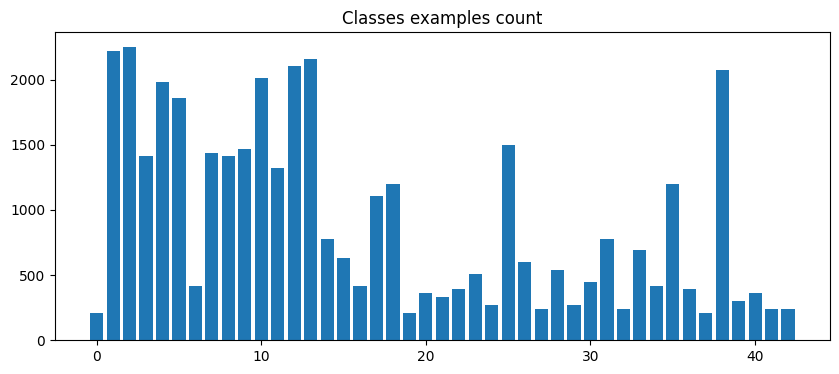

In [6]:
class_examples_num = dict(Counter(dataset.targets))
plot_bar(class_examples_num, "Classes examples count",  size=(10, 4))

In [7]:
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=14, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training the conditional VAE model

In [8]:
vae = VAE(input_dim=3, hidden_dims=[32, 64, 128, 2048, 512], latent_dim=128, num_classes=43, label_emb_dim=32, device=device).to(device)

In [9]:
vae.load("weights/vae.pth")
# train_vae(vae, device, train_dataloader, epochs=50, lr=1e-3)


## Training the conditional Diffusion model

In [10]:
diff_model = UNet(input_ch=3, base_ch=64, timestep_emb=128, num_classes=43, label_emb_dim=32).to(device)

In [11]:
diff_model.load("weights/ddpm.pth")
# train_diffusion(diff_model, train_dataloader, epochs=50, lr=1e-4, device=device)


We mirror the original training dataset distribution for conditioning vector (1000 samples) to better match the test set data.

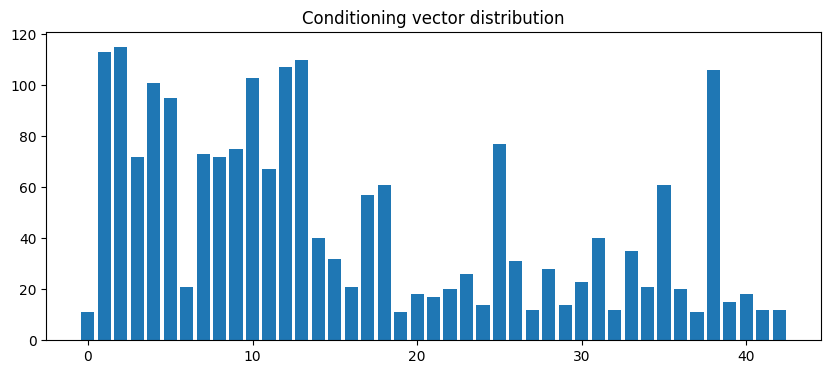

In [12]:
cond_distr = create_conditioning_distribution(dataset, sample_size=2000)
conditioning_vector = create_conditioning_vector(cond_distr)
plot_bar(cond_distr , "Conditioning vector distribution",  size=(10, 4))

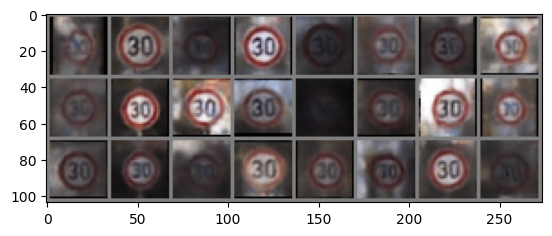

In [13]:
generated_images_vae = vae.generate(torch.Tensor(conditioning_vector).long().to(device))
show_generated(generated_images_vae, 100, 124)


In [14]:
generated_images_diff = generate(diff_model, conditioning_vector.to(device))

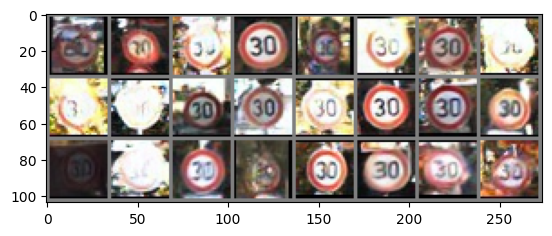

In [15]:
show_generated(generated_images_diff.detach().cpu(), 100, 124)

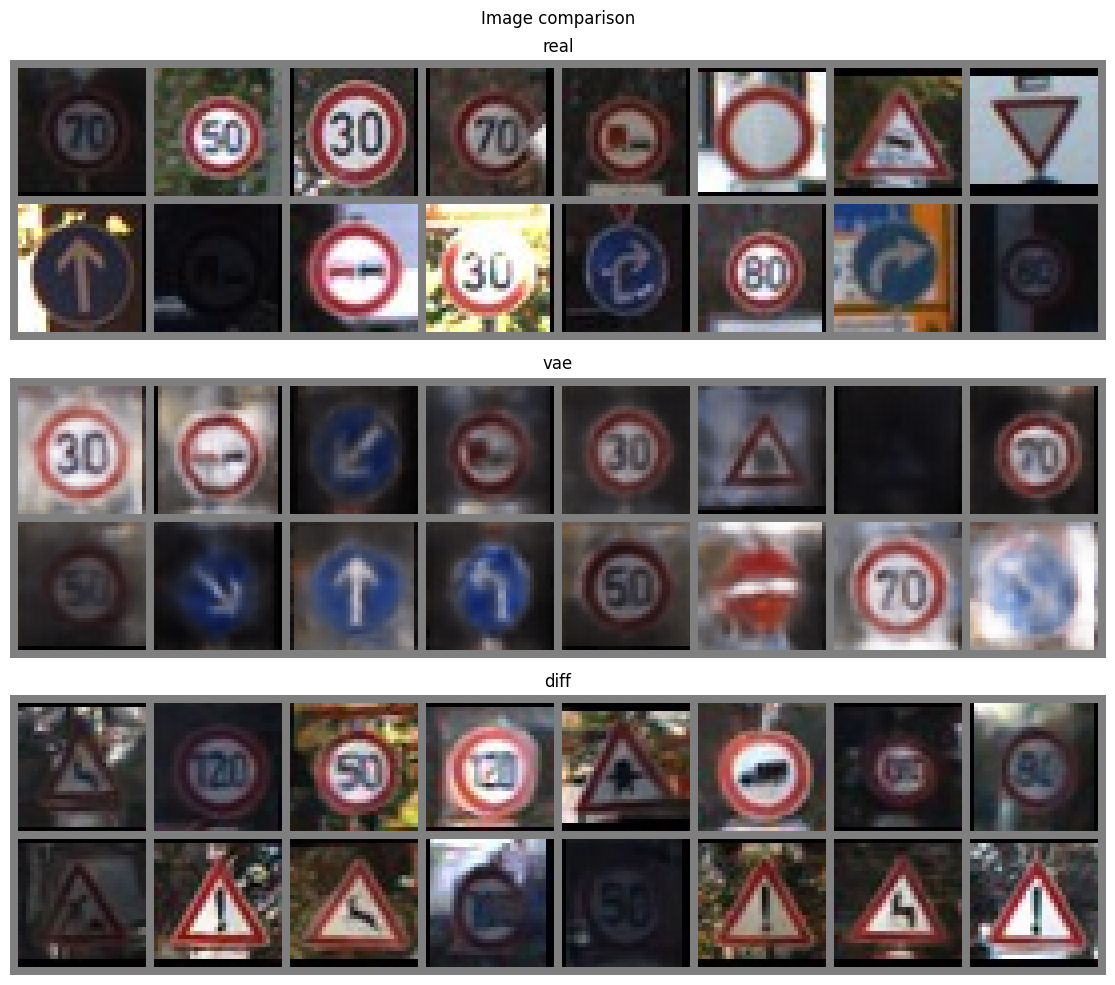

In [16]:
images = {"real": dataset, "vae": generated_images_vae, "diff": generated_images_diff}

visualize_images_grid(images, figsize=(20, 10), title="Image comparison")


In [ ]:
trainable_params_vae = sum(p.numel() for p in vae.parameters() if p.requires_grad)
trainable_params_diff = sum(p.numel() for p in diff_model.parameters() if p.requires_grad)
print(f"Trainable parameters (vae): {trainable_params_vae}")
print(f"Trainable parameters (diff): {trainable_params_diff}")

Trainable parameters (vae): 2662307
Trainable parameters (diff): 3595171


In [ ]:
fid_vae = measure_fid(dataset, generated_images_vae, device)
fid_diff = measure_fid(dataset, generated_images_diff, device)
df = pd.DataFrame({"Model": ["VAE", "Diffusion"], "FID": [fid_vae, fid_diff]})


In [ ]:
# from sklearn.model_selection import train_test_split

# all_idxs = list(range(len(dataset)))              # ImageFolder or any Dataset
# all_labels = [dataset.targets[i] for i in all_idxs]

# sub_idxs, _ = train_test_split(
#     all_idxs,
#     train_size=2000,            # absolute number or 0.25
#     stratify=all_labels,
#     random_state=42)              # reproducible

# subset = torch.utils.data.Subset(dataset, sub_idxs)


In [19]:
# import torch
# from pathlib import Path
# from torchvision.utils import save_image          # part of torchvision >=0.5

# def save_tanh_batch(batch: torch.Tensor,
#                     out_dir: str | Path,
#                     *,
#                     prefix: str = "img_"):
#     out_dir = Path(out_dir)
#     out_dir.mkdir(parents=True, exist_ok=True)

#     # 1‒2. detach, move to CPU, safety-clamp
#     imgs = batch.detach().cpu().clamp(-1, 1)
    
#     # 3. map [-1,1] → [0,1]  --- torchvision will do ×255 + uint8 internally
#     imgs = (imgs + 1) / 2

#     # 4‒6. per-image save via torchvision (wraps Pillow)
#     for i, img in enumerate(imgs):
#         fname = out_dir / f"{prefix}{i:04d}.jpg"   # zero-padded index
#         save_image(img, fname, padding=0)

# save_tanh_batch(generated_images, "samples")

In [ ]:
from torch.utils.data import Subset, Dataset
from torchvision import transforms

class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


def to_uint8(img):
    img = (img + 1) / 2             
    img = img.clamp(0, 1)           
    img = (img * 255).round()       
    return img.to(torch.uint8)


import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import utils
from collections import Counter


def imshow(img):
    if img.dtype != torch.uint8:
        img = to_uint8(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def visualize_images2(dataloader, classes, figsize=(20, 10), batch_size=16):
    plt.figure(figsize=figsize)
    images, labels = next(iter(dataloader))

    imshow(utils.make_grid(images))  

    print(" ".join("%5s" % classes[labels[j]] for j in range(batch_size)))


def show_generated2(generated_images, range_low=0, range_high=-1):
    imshow(utils.make_grid(generated_images[range_low:range_high]))

def visualize_images3(images, labels=None, classes=None, nrow=8, figsize=(12, 6), title=None):
    """
    Visualizes a batch or single image tensor in [0, 255] range (uint8 or float).

    Args:
        images: Tensor of shape (B, C, H, W) or (C, H, W)
        labels: Optional list or tensor of labels
        classes: Optional mapping from label index to class name
        nrow: Number of images per row (for batch mode)
        figsize: Figure size
        title: Optional title for the plot
    """
    # Ensure batch dimension
    if images.ndim == 3:
        images = images.unsqueeze(0)

    # Convert to float [0, 1] for display
    if images.dtype == torch.uint8:
        images = images.float() / 255

    # Create grid of images
    grid = utils.make_grid(images, nrow=nrow, padding=2)

    plt.figure(figsize=figsize)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    if title:
        plt.title(title)

    # Add labels if provided
    if labels is not None and classes is not None:
        class_names = [classes[int(label)] for label in labels]
        print("Labels:", class_names)

    plt.show()

Min: 0
Max: 255


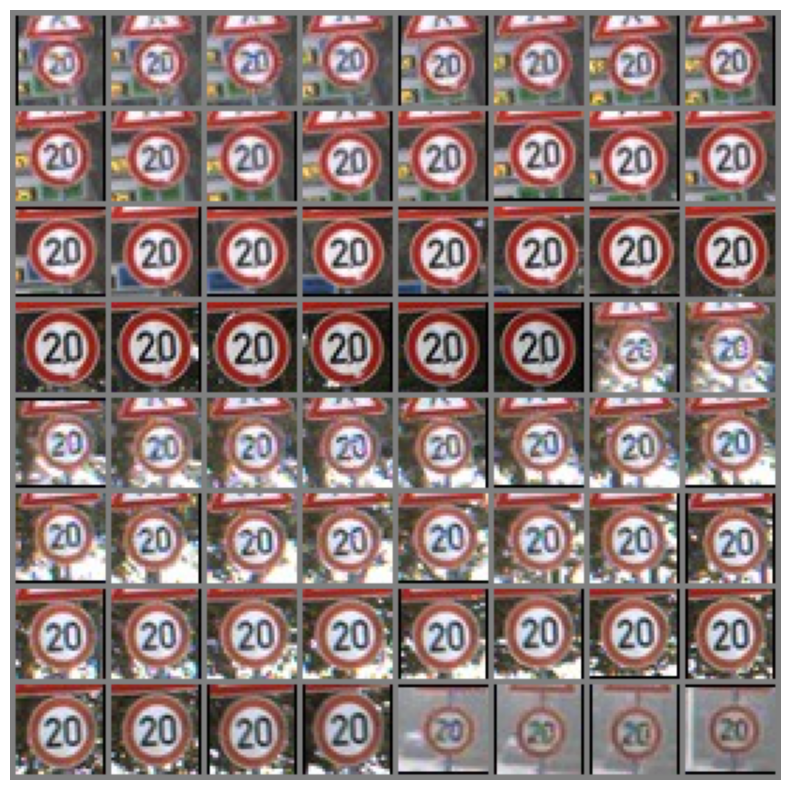

00000 00000 00000 00000 00000 00000 00000 00000 00000 00000 00000 00000 00000 00000 00000 00000


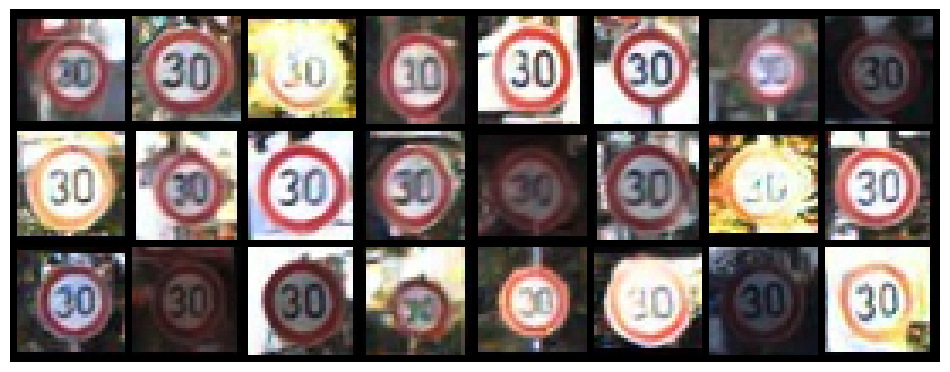

FID: 36.61009979248047


In [39]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torch.utils.data import TensorDataset
fid = FrechetInceptionDistance(feature=2048, normalize=False).to(device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3) 
])
real_dataset = datasets.ImageFolder("data/trafic_32", transform=transform)
# target_class_idx = real_dataset.class_to_idx['00002']
# filtered_indices = [i for i, (_, label) in enumerate(real_dataset) if label == target_class_idx]
# subset = torch.utils.data.Subset(real_dataset, filtered_indices)
transform = transforms.Compose([
    transforms.Normalize((0.5,)*3, (0.5,)*3) 
])
real_loader  = DataLoader(real_dataset,
                          batch_size=64,       
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True)


generated_images = to_uint8(generated_images)
gen_dataset = TensorDataset(generated_images.cpu())            
gen_loader  = DataLoader(gen_dataset,
                         batch_size=64,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True)
print("Min:", generated_images.min().item())
print("Max:", generated_images.max().item())
visualize_images2(real_loader, classes, figsize=(20, 10))
visualize_images3(generated_images[100:124].cpu())

fid.eval()
with torch.no_grad():
    for (imgs,) in gen_loader:                  
        fid.update(imgs.to(device), real=True)

    for imgs, label in real_loader:                     
        fid.update(to_uint8(imgs).to(device), real=False)

score = fid.compute()
print("FID:", score.item())
fid.reset()

In [ ]:
import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

### Denormalize and verify before saving

In [ ]:
generated_images = to_uint8(generated_images)
print("Min:", generated_images.min().item())
print("Max:", generated_images.max().item())
print("Generated images shape:", generated_images.shape)
print("Generated images dtype:", generated_images.dtype)
torch.save(generated_images.detach().cpu(), "generated_images.pt")

Generated images shape: torch.Size([1000, 3, 32, 32])
Generated images dtype: torch.uint8
